# Train, fit, and evaluate classifier <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


## Description



## Load packages

In [1]:
# -- scikit-learn classifiers, uncomment the one of interest----

# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier

import os
import sys
import joblib
import numpy as np
import pandas as pd
from joblib import dump
import subprocess as sp
import dask.array as da
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, f1_score, balanced_accuracy_score

sys.path.append('../../Scripts')
from deafrica_classificationtools import spatial_clusters, SKCV

%load_ext autoreload
%autoreload 2

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/env/lib/python3.6/site-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)


## Analysis Parameters

* `training_data`: Name and location of the training data `.txt` file output from runnning `1_Extract_training_data.ipynb`
* `Classifier`: This parameter refers to the scikit-learn classification model to use, first uncomment the classifier of interest in the `Load Packages` section and then enter the function name into this parameter `e.g. Classifier = SVC`   
* `class_dict`: A dictionary mapping the 'string' name of the classes to the integer values that represent our classes in the training data (e.g. `{'crop': 1., 'noncrop': 0.}`)
* `metric` : A single string that denotes the scorer used to find the best parameters for refitting the estimator to evaluate the predictions on the test set. See the scoring parameter page [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for a pre-defined list of options.
* `inner_cv_splits` : 
* `outer_cv_splits` :

### Spatial K-Fold Cross Validation Parameters

The deafrica function `SKCV` (spatial k-fold cross validation) is a custom function similar to `sklearn.model_selection.KFold` but instead works on spatial coordinate data.  Coordinate data is grouped according to either a Guassian Mixture, KMeans, or Heirachical clustering algorithm. Grouping by spatial clusters is preferred over plain random splits for spatial data to avoid overestimating validation scores due to the inherent autocorrelation of spatial data. To use `SKCV` we need to set more parameters: 

* `test_size` : This will determine what fraction of the dataset will be set aside as the testing dataset. There is a trade-off here between having a larger test set that will help us better determine the quality of our classifier, and leaving enough data to train the classifier. A good deafult is to set 10-20 % of your dataset aside for testing purposes.
* `cluster_method` : Which algorithm to use to create spatial groups, either `'Hierarchical'`, `'GMM'` or `'KMeans'`. Key word arguments for these algorithms can also be passed to the function if non-default behaviour is required. See the docs for [GMM](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html), [Kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and [Heirarchical](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) for options. 
* `max_distance`:  This parameter is used when using the 'Heirarchical' clustering method. The maximum distance describes the maximum euclidean distances between all observations in a cluster. The units of distance depend on the map projection of the coordinate data. e.g if using a UTM projection, then the `max_distance` is in metres, so to set the maximum distance of each cluster to 200 km, `max_distance=200000`. 
* `n_clusters` : Number of spatial clusters to create using the coordinate values of the training data samples. This option only applies if using the 'GMM' or 'Kmeans' clustering methods, if using the 'Heirarchical' method then the number of clusters is determined automatically using the maximum distance threshold.
* `kfold_method` : Which stratgey to use to split to the data. One of either `'SpatialShuffleSplit'` or `'SpatialKFold'`.
* `balance` : if setting `kfold_method` to `'SpatialShuffleSplit'` this should be an integer (10 is a good deafult) that represents the number of splits generated per iteration to try to balance the amount of data in each set so that *test_size* and *train_size* are respected. If setting `kfold_method` to `'SpatialKFold'` then this value should be either `True` or `False`.  If False, each fold will have the same number of clusters (which can have different number of data points in them).

In [2]:
training_data = "results/training_data/gm_three_seasons_training_data_allfls.txt"
coordinate_data = "results/training_data/training_data_coordinates.txt"

Classifier = RandomForestClassifier

class_dict = {'crop':1, 'noncrop':0}

metric = 'balanced_accuracy' #good for binary classifications

inner_cv_splits = 5

outer_cv_splits = 10

test_size = 0.20

cluster_method = 'Hierarchical'

max_distance = 200000

n_clusters=None

kfold_method = 'SpatialShuffleSplit'

balance = 10

### Automatically find the number of cpus

In [3]:
try:
    ncpus = int(float(sp.getoutput('env | grep CPU')[-4:]))
except:
    ncpus = int(float(sp.getoutput('env | grep CPU')[-3:]))

print('ncpus = '+str(ncpus))

ncpus = 31


## Import training  and coordinate data

In [4]:
# load the data
model_input = np.loadtxt(training_data)
coordinates = np.loadtxt(coordinate_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]

# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

#convert variable names into sci-kit learn nomenclature
X = model_input[:, model_col_indices]
y = model_input[:, 0]

After setting the parameters, lets first generate spatial clusters using the DE Africa function `spatial_clusters` to visualize how our data will be grouped.  You may want to refine the parameters to achieve a grouping that works for your dataset by resetting the parameters above

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


n clusters = 125


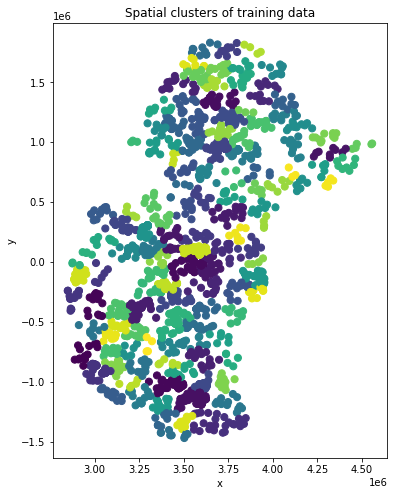

In [5]:
#create clustes
spatial_groups = spatial_clusters(coordinates=coordinates,
                                  method=cluster_method,
                                  max_distance=max_distance,
                                  n_groups=n_clusters)

#plot
plt.figure(figsize=(6,8))
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=spatial_groups,
            s=50, cmap='viridis');
plt.title('Spatial clusters of training data')
plt.ylabel('y')
plt.xlabel('x');

## Calculate an unbiased performance estimate via nested cross-validation.  

https://jmlr.csail.mit.edu/papers/v11/cawley10a.html

https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/


> **Note**: the parameters in the `param_grid` object depend on the classifier being used. The default example is set up for a random forest classifier, to adjust ther paramaters to suit a different classifier, look up the important parameters under the relevant [sklearn documentation](https://scikit-learn.org/stable/supervised_learning.html). 

In [6]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'class_weight': ['balanced', None],
    'max_features': ['auto', 'log2', None],
    'n_estimators': [250,300,400,500],
    'criterion':['gini', 'entropy']
}

In [7]:
# create outer k-fold splits
outer_cv = SKCV(
    coordinates=coordinates,
    max_distance=max_distance,
    n_splits=outer_cv_splits,
    cluster_method=cluster_method,
    kfold_method=kfold_method,
    test_size=test_size,
    balance=balance,
)

# lists to store results of CV testing
acc = []
f1 = []
roc_auc = []
# loop through outer splits and test predictions
for train_index, test_index in outer_cv.split(coordinates):

    model = Classifier(random_state=1)

    # index training, testing, and coordinate data
    X_tr, X_tt = X[train_index, :], X[test_index, :]
    y_tr, y_tt = y[train_index], y[test_index]
    coords = coordinates[train_index]

    # inner split on data within outer split
    inner_cv = SKCV(
        coordinates=coords,
        max_distance=max_distance,
        n_splits=inner_cv_splits,
        cluster_method=cluster_method,
        kfold_method=kfold_method,
        test_size=test_size,
        balance=balance,
    )
    
    #perfrom grid search on hyperparameters
    clf = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=metric,
        n_jobs=ncpus,
        cv=inner_cv.split(coords),
        refit=True,
    )
    
    clf.fit(X_tr, y_tr)
    #predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)

    # evaluate model w/ multiple metrics
    # ROC AUC
    probs = best_model.predict_proba(X_tt)
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_tt, probs)
    auc_ = auc(fpr, tpr)
    roc_auc.append(auc_)
    # Overall accuracy
    ac = balanced_accuracy_score(y_tt, pred)
    acc.append(ac)
    # F1 scores
    f1_ = f1_score(y_tt, pred)
    f1.append(f1_)

n clusters = 125
n clusters = 100
n clusters = 100
n clusters = 100
n clusters = 100
n clusters = 100
n clusters = 100
n clusters = 100
n clusters = 100
n clusters = 100
n clusters = 100


In [8]:
print("=== Nested Spatial K-Fold Cross-Validation Scores ===")
print("Mean balanced accuracy: "+ str(round(np.mean(acc), 2)))
print("Std balanced accuracy: "+ str(round(np.std(acc), 2)))
print('\n')
print("Mean F1: "+ str(round(np.mean(f1), 2)))
print("Std F1: "+ str(round(np.std(f1), 2)))
print('\n')
print("Mean roc_auc: "+ str(round(np.mean(roc_auc), 3)))
print("Std roc_auc: "+ str(round(np.std(roc_auc), 2)))

=== Nested Spatial K-Fold Cross-Validation Scores ===
Mean balanced accuracy: 0.74
Std balanced accuracy: 0.07


Mean F1: 0.7
Std F1: 0.1


Mean roc_auc: 0.845
Std roc_auc: 0.06


## Optimize hyperparameters

Hyperparameter searches are a required process in machine learning. Machine learning models require certain “hyperparameters”, model parameters that can be learned from the data. Finding these good values for these parameters is a “hyperparameter search” or an “hyperparameter optimization.”

To optimize the parameters in our model, we use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to exhaustively search through a set of parameters and determine the combination that will result in the highest accuracy based upon the accuracy metric defined.


In [9]:
#generate n_splits of train-test_split
ss = SKCV(
        coordinates=coordinates,
        max_distance=max_distance,
        n_groups=n_clusters,
        n_splits=outer_cv_splits,
        cluster_method=cluster_method,
        kfold_method=kfold_method,
        test_size=test_size,
        balance=balance
        )

In [10]:
#instatiate a gridsearchCV
clf = GridSearchCV(Classifier(),
                   param_grid,
                   scoring=metric,
                   verbose=1,
                   cv=ss.split(coordinates),
                   n_jobs=ncpus)

clf.fit(X, y)

print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print("The "+metric+" score using these parameters is: ")
print(round(clf.best_score_, 2))

n clusters = 125
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=31)]: Using backend LokyBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Done 138 tasks      | elapsed:   47.7s
[Parallel(n_jobs=31)]: Done 388 tasks      | elapsed:  2.7min
[Parallel(n_jobs=31)]: Done 480 out of 480 | elapsed:  3.9min finished


The most accurate combination of tested parameters is: 
{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_features': 'auto',
 'n_estimators': 400}


The balanced_accuracy score using these parameters is: 
0.69


## Fit a model

Using the best parameters from our hyperparmeter optmization search, we now fit our model on all the data to give the best possible model.

In [11]:
#create a new model
new_model = Classifier(**clf.best_params_, random_state=1, n_jobs=ncpus)
new_model.fit(X, y)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=400, n_jobs=31, random_state=1)

## Save the model

Running this cell will export the classifier as a binary`.joblib` file. This will allow for importing the model in the subsequent script, `4_Predict.ipynb` 


In [12]:
dump(new_model, 'results/gm_three_seasons_ml_model.joblib')

['results/gm_three_seasons_ml_model.joblib']

## Recommended next steps

To continue working through the notebooks in this `Scalable Machine Learning on the ODC` workflow, go to the next notebook `4_Predict.ipynb`.

1. [Extracting_training_data](1_Extracting_training_data.ipynb) 
2. [Inspect_training_data](2_Inspect_training_data.ipynb)
3. **Train_fit_evaluate_classifier**
4. [Predict](4_Predict.ipynb)
5. [Accuracy_assessment](5_Accuracy_assessment.ipynb)
6. [Object-based_filtering](6_Object-based_filtering_(optional).ipynb)


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** August 2020


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)